In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
import importlib

In [123]:
from training import toy
importlib.reload(toy)
torch.manual_seed(42)

batch_size = 2

#trainset = toy.CubicToyDataset(min=-4, max=4, sample_count=20, noise=3, normalize=True)
trainset = toy.TrigonometricToyDataset(sample_count=200, normalize=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

device = torch.device("cpu")

In [135]:
import matplotlib.pyplot as plt

def plot(eval):
    #plt.xlim(-6, 6)
    #plt.ylim(-150, 150)
    #t = torch.linspace(-6, 6, 50)
    plt.xlim(-0.2, 1.2)
    plt.ylim(-0.4, 1.2)
    t = torch.linspace(-0.2, 1.2, 100)

    plt.plot(t, trainset.eval_value(t), color="blue") # Actual function

    means, variances = torch.zeros(len(t)), torch.zeros(len(t))
    with torch.no_grad():
        means, variances = eval(torch.unsqueeze(t * trainset.x_norm, -1))
    means = torch.squeeze(means, -1) / trainset.y_norm
    variances = torch.squeeze(variances, -1) / trainset.y_norm**2

    higher_bound = means + 3 * torch.sqrt(variances)
    lower_bound = means - 3 * torch.sqrt(variances)
    plt.plot(t, means, color="red") # Averaged predictions
    plt.fill_between(t, lower_bound, higher_bound, color="lightgrey")
    print(f"RMSE {torch.sqrt(F.mse_loss(means, t**3))}")

    xs, ys = zip(*(((x / trainset.x_norm).numpy(), (y / trainset.y_norm).numpy()) for (x, y) in trainset))
    plt.scatter(xs, ys, s=4, color="blue")

Epoch 0: loss 0.14295105636119843
Epoch 10: loss 0.052834853529930115
Epoch 20: loss 0.04927733540534973
Epoch 30: loss 0.046472229063510895
Epoch 40: loss 0.04251326993107796
Epoch 50: loss 0.0358467660844326
Epoch 60: loss 0.026127565652132034
Epoch 70: loss 0.01625250279903412
Epoch 80: loss 0.012476321309804916
Epoch 90: loss 0.009845749475061893
Final loss 0.00934274960309267
RMSE 0.4334942698478699


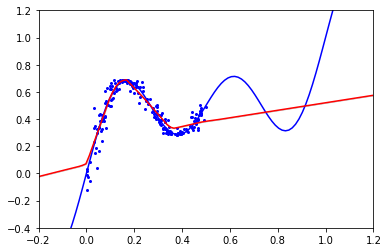

In [136]:
# Point estimator with L2 regularization

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU(), nn.Linear(16, 1))
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
for epoch in range(100):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")
plot(lambda input: (model(input), torch.tensor(0)))

Epoch 0: loss 0.07664556056261063
Epoch 10: loss 0.04259070008993149
Epoch 20: loss 0.028614580631256104
Epoch 30: loss 0.022424090653657913
Epoch 40: loss 0.019200287759304047
Epoch 50: loss 0.01816585101187229
Epoch 60: loss 0.015178751200437546
Epoch 70: loss 0.013549032621085644
Epoch 80: loss 0.013085280545055866
Epoch 90: loss 0.011193300597369671
Final loss 0.011330639012157917
RMSE 0.7644058465957642


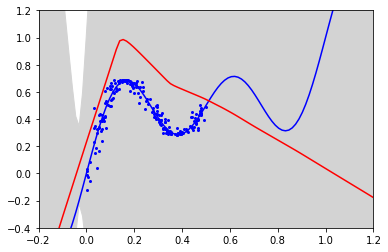

In [141]:
# SWAG trained with Adam and L2 regularization (lr is currently not adjusted for SWAG)

from training import swag
importlib.reload(swag)

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 1))
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001) # Without weight_decay the covariance matrix is not positive definit???
wrapper = swag.SWAGWrapper(model, 5, 10)
for epoch in range(100):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    wrapper.update(epoch)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_swag(input):
    return wrapper.sample(input, 100, model, 1)

plot(eval_swag)

Training model 0
  Epoch 0: loss -0.41857919096946716
  Epoch 10: loss -1.224941611289978
  Epoch 20: loss -1.2495052814483643
  Epoch 30: loss -1.2806215286254883
  Epoch 40: loss -1.2681962251663208
  Epoch 50: loss -1.2423646450042725
  Final loss -1.268056869506836
Training model 1
  Epoch 0: loss -0.7062875628471375
  Epoch 10: loss -1.1990635395050049
  Epoch 20: loss -1.2549412250518799
  Epoch 30: loss -1.2356629371643066
  Epoch 40: loss -1.2626112699508667
  Epoch 50: loss -1.2557055950164795
  Final loss -1.27237868309021
Training model 2
  Epoch 0: loss -0.5369042158126831
  Epoch 10: loss -1.2232940196990967
  Epoch 20: loss -1.2415781021118164
  Epoch 30: loss -1.2645992040634155
  Epoch 40: loss -1.2969143390655518
  Epoch 50: loss -1.2336642742156982
  Final loss -1.2595497369766235
Training model 3
  Epoch 0: loss -0.625957727432251
  Epoch 10: loss -1.2038848400115967
  Epoch 20: loss -1.241008996963501
  Epoch 30: loss -1.2786535024642944
  Epoch 40: loss -1.26044487

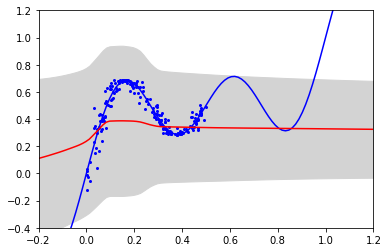

In [146]:
# Ensemble of point estimators with L2 regularization

from training import ensemble
importlib.reload(ensemble)

torch.manual_seed(42)

adversarial_training = True

def nll_loss(mean, variance, target):
    return (torch.log(variance) / 2 + torch.pow(target - mean, 2) / (2 * variance)).sum() / mean.shape[0]

ensemble_count = 5
#models = [nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 2)) for _ in range(ensemble_count)]
models = [nn.Sequential(nn.Linear(1, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU(), nn.Linear(16, 2)) for _ in range(ensemble_count)]
for i, model in enumerate(models):
    print(f"Training model {i}")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
    for epoch in range(60):
        epoch_loss = torch.tensor(0, dtype=torch.float)
        for data, target in trainloader:
            optimizer.zero_grad()
            if adversarial_training:
                data.requires_grad = True
            
            output = model(data)
            mean, variance = output[:,0], torch.log1p(torch.exp(output[:,1])) + 10e-6
            loss = nll_loss(mean, variance, target)

            if adversarial_training:
                loss.backward(retain_graph = True)
                a_data = data + 0.01 * torch.sign(data.grad)
                optimizer.zero_grad()
                a_target = trainset.eval_value(a_data)
                a_output = model(data)
                a_mean, a_variance = a_output[:,0], torch.log1p(torch.exp(a_output[:,1])) + 10e-6
                a_loss = nll_loss(a_mean, a_variance, a_target)
                loss += a_loss

            loss.backward()
            optimizer.step()
            epoch_loss += loss
        if epoch % 10 == 0:
            print(f"  Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
    print(f"  Final loss {epoch_loss / (len(trainloader) * batch_size)}")

importlib.reload(ensemble)
def eval_esemble(input):
    return ensemble.combined_variance_output(input, models)

plot(eval_esemble)

Epoch 0: loss 9.954691886901855
Epoch 10: loss 5.201352119445801
Epoch 20: loss 4.051377773284912
Epoch 30: loss 3.545173406600952
Epoch 40: loss 3.323916435241699
Epoch 50: loss 3.1933045387268066
Epoch 60: loss 3.142683744430542
Epoch 70: loss 3.113374948501587
Epoch 80: loss 3.0844671726226807
Epoch 90: loss 3.030409336090088
Final loss 3.0920794010162354
RMSE 0.5072435736656189


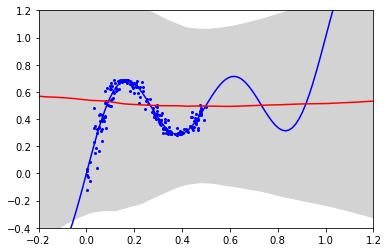

In [148]:
# Bayesian NN (Bayes-by-Backprop)

from training.util import GaussianMixture
import training.bbb as bbb
importlib.reload(bbb)

torch.manual_seed(42)

pi = 0.5 # 0.25, 0.5, 0.75
sigma1 = np.exp(-1) # 0, 1, 2
sigma2 = np.exp(-7) # 6, 7, 8
prior = GaussianMixture(pi, sigma1, sigma2)

#model = nn.Sequential(bbb.BayesianLinearLayer(1, 100, prior, prior, device, weight_draw="minibatch"), nn.ReLU(), bbb.BayesianLinearLayer(100, 1, prior, prior, device, weight_draw="minibatch"))
model = nn.Sequential(bbb.BayesianLinearLayer(1, 16, prior, prior, device, weight_draw="minibatch"), nn.ReLU(), bbb.BayesianLinearLayer(16, 16, prior, prior, device, weight_draw="minibatch"), nn.ReLU(), bbb.BayesianLinearLayer(16, 16, prior, prior, device, weight_draw="minibatch"), nn.ReLU(), bbb.BayesianLinearLayer(16, 1, prior, prior, device, weight_draw="minibatch"))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(100):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        #mean, variance = output[:,0], torch.log1p(torch.exp(output[:,1])) + 10e-6
        #dist = torch.distributions.Normal(mean, variance)
        log_prior = sum([getattr(layer, "log_prior", 0) for layer in model])
        log_posterior = sum([getattr(layer, "log_posterior", 0) for layer in model])
        loss = (log_posterior - log_prior) / len(trainloader) + F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_bbb(input):
    samples = 10
    outputs = torch.zeros((input.shape[0], samples))
    for i in range(samples):
        outputs[:,i] = torch.squeeze(model(input), -1)
    return torch.mean(outputs, dim=1), torch.var(outputs, dim=1)

plot(eval_bbb)